# Capstone Project: Prediksi Keterlambatan Pengiriman E-Commerce
**Judul:** Perbandingan Logistic Regression dan XGBoost untuk Prediksi Keterlambatan Pengiriman E-Commerce

## Tujuan
Membangun model machine learning untuk memprediksi apakah pengiriman akan terlambat atau tepat waktu,
serta membandingkan performa:
1) Logistic Regression (baseline)
2) XGBoost (advanced)

## Output yang dihasilkan
- Notebook end-to-end (EDA → preprocessing → modeling → evaluasi → analisis)
- Model terbaik tersimpan (joblib) untuk deployment (Streamlit)

In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, classification_report
)

import joblib

Menngunakan:
- Pandas/Numpy untuk olah data
- Pipeline + ColumnTransformer agar preprocessing rapi dan mencegah data leakage
- Logistic Regression untuk baseline
- XGBoost untuk model advanced
- Evaluasi: Accuracy, F1-score, ROC-AUC, Confusion Matrix, ROC Curve
- joblib untuk simpan model terbaik

In [6]:
DATA_PATH = "Train.csv"  
df = pd.read_csv(DATA_PATH)

df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [7]:
df.shape, df.columns

((10999, 12),
 Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
        'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
        'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
        'Reached.on.Time_Y.N'],
       dtype='object'))

Di tahap ini kita memastikan dataset terbaca dengan benar, dan melihat ukuran dataset serta kolomnya.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [9]:
df.isna().sum().sort_values(ascending=False)

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [10]:
TARGET = "Reached.on.Time_Y.N"
df[TARGET].value_counts()

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

In [11]:
df[TARGET].value_counts(normalize=True) * 100

Reached.on.Time_Y.N
1    59.669061
0    40.330939
Name: proportion, dtype: float64

Cek:
- tipe data tiap kolom
- apakah ada missing value
- distribusi target (apakah imbalanced)

Jika imbalanced, metrik F1-score dan ROC-AUC lebih relevan dibanding accuracy saja.

Kolom `ID` adalah penanda unik, bukan fitur penyebab keterlambatan.
Kalau dipakai, model bisa “belajar” pola yang tidak bermakna.
Karena itu kolom `ID` kita drop.

In [12]:
df_model = df.drop(columns=["ID"])

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

X.shape, y.shape

((10999, 10), (10999,))

In [13]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

categorical_cols, numeric_cols

(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'],
 ['Customer_care_calls',
  'Customer_rating',
  'Cost_of_the_Product',
  'Prior_purchases',
  'Discount_offered',
  'Weight_in_gms'])

Pada dataset ini, kolom kategorikal (object):
- Warehouse_block
- Mode_of_Shipment
- Product_importance
- Gender

Kolom lainnya numerik.
Kolom kategorikal perlu One-Hot Encoding agar bisa diproses model.

Kita pakai stratify supaya proporsi kelas target di train dan test tetap sama.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((8799, 10), (2200, 10))

Kenapa Pipeline penting?
- Preprocessing fit hanya di data train
- Mencegah data leakage
- Rapi dan gampang dipakai ulang saat deployment (Streamlit)

In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # penting untuk Logistic Regression
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

Logistic Regression dipakai sebagai baseline karena:
- sederhana, cepat
- cocok untuk klasifikasi biner

Kita pakai class_weight="balanced" untuk membantu jika kelas target tidak seimbang.

In [16]:
lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

acc_lr, f1_lr, auc_lr

(0.6454545454545455, 0.6331138287864534, 0.7169833191800664)

In [17]:
print("=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test, y_pred_lr))

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       887
           1       0.83      0.51      0.63      1313

    accuracy                           0.65      2200
   macro avg       0.68      0.68      0.65      2200
weighted avg       0.71      0.65      0.64      2200



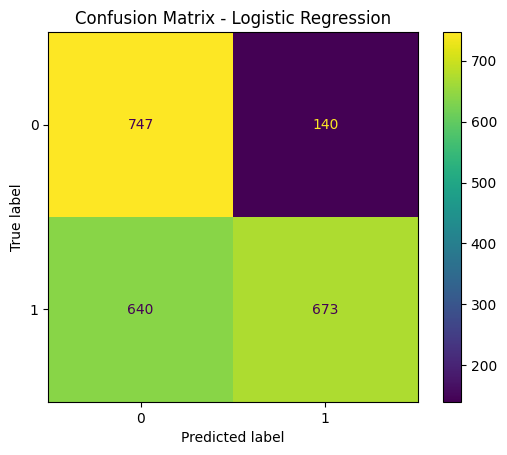

In [18]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm_lr).plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

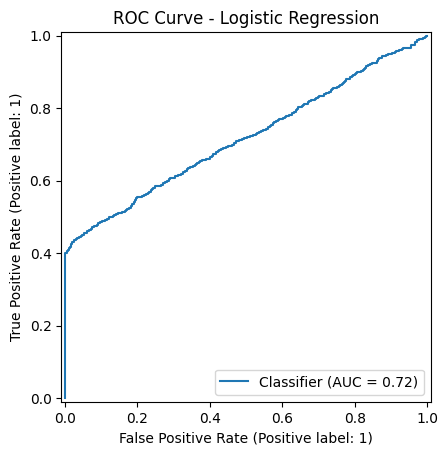

In [19]:
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC Curve - Logistic Regression")
plt.show()

XGBoost biasanya unggul pada data tabular karena menangkap hubungan non-linear.

In [20]:
from xgboost import XGBClassifier

Untuk imbalanced, kita hitung scale_pos_weight = (jumlah negatif / jumlah positif) pada data train.

In [21]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

neg, pos, scale_pos_weight

(np.int64(3549), np.int64(5250), np.float64(0.676))

In [22]:
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

acc_xgb, f1_xgb, auc_xgb

(0.6759090909090909, 0.6533787068546427, 0.7346129374883547)

In [23]:
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb))

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.56      0.92      0.70       887
           1       0.90      0.51      0.65      1313

    accuracy                           0.68      2200
   macro avg       0.73      0.72      0.67      2200
weighted avg       0.76      0.68      0.67      2200



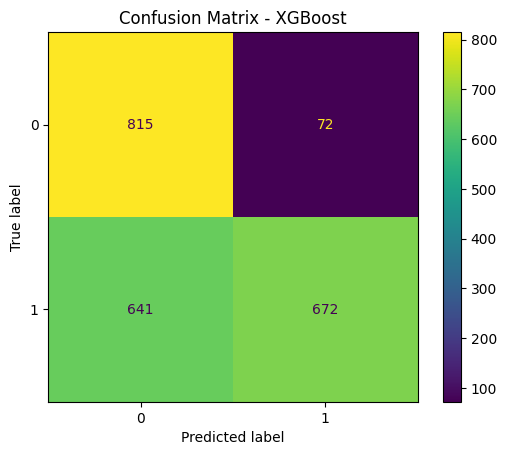

In [24]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot()
plt.title("Confusion Matrix - XGBoost")
plt.show()

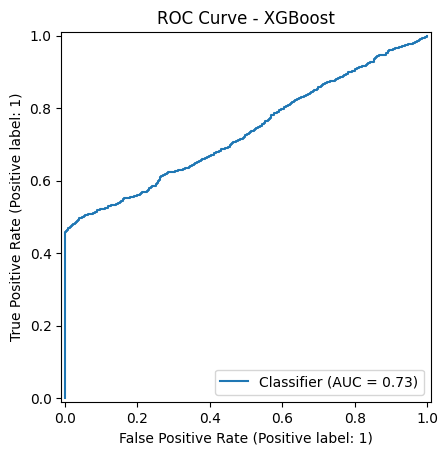

In [25]:
RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("ROC Curve - XGBoost")
plt.show()

Kita bandingkan performa dengan:
- Accuracy
- F1-score (utama untuk klasifikasi yang berpotensi imbalanced)
- ROC-AUC (kemampuan memisahkan kelas)

In [26]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "Accuracy": [acc_lr, acc_xgb],
    "F1-Score": [f1_lr, f1_xgb],
    "ROC-AUC": [auc_lr, auc_xgb]
}).sort_values(by="F1-Score", ascending=False)

results

,Model,Accuracy,F1-Score,ROC-AUC
1,XGBoost,0.675909,0.653379,0.734613
0,Logistic Regression,0.645455,0.633114,0.716983


Feature importance dipakai untuk melihat fitur mana yang paling berpengaruh.

In [27]:
# Ambil nama fitur setelah One-Hot
preprocessor_fitted = xgb_model.named_steps["preprocess"]
ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"]

cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_cols, cat_feature_names])

xgb_clf = xgb_model.named_steps["clf"]
importances = xgb_clf.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)

,feature,importance
4,Discount_offered,0.384175
3,Prior_purchases,0.070975
5,Weight_in_gms,0.053503
9,Warehouse_block_D,0.035040
2,Cost_of_the_Product,0.034568
0,Customer_care_calls,0.034415
12,Mode_of_Shipment_Road,0.032928
13,Mode_of_Shipment_Ship,0.031751
7,Warehouse_block_B,0.031690
14,Product_importance_high,0.031528


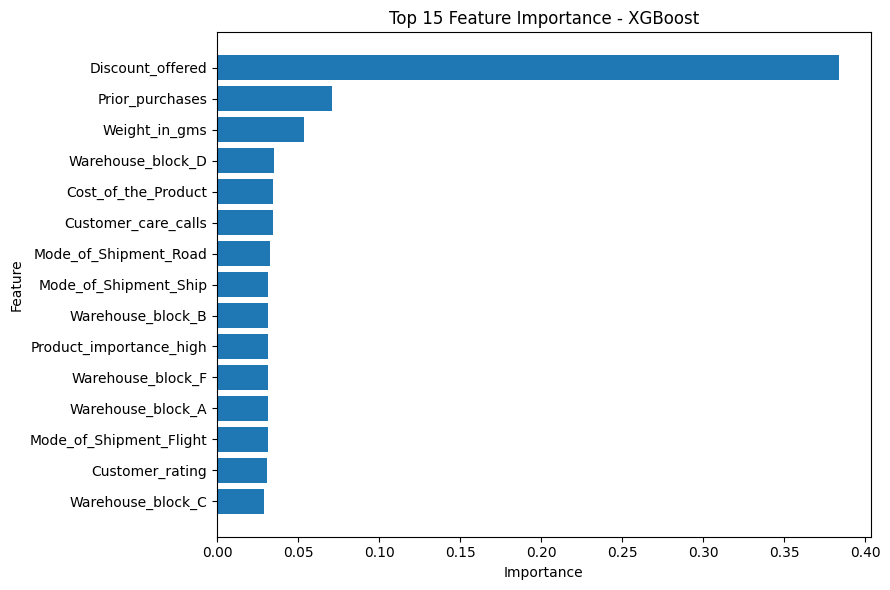

In [28]:
top_n = 15
fi_top = fi.head(top_n)[::-1]

plt.figure(figsize=(9, 6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title(f"Top {top_n} Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Kriteria pemilihan model:
- Utamakan F1-score
- Jika F1 mirip, lihat ROC-AUC
Setelah itu simpan model terbaik untuk deployment.

In [29]:
best_model_name = results.iloc[0]["Model"]
best_model = lr_model if best_model_name == "Logistic Regression" else xgb_model
best_model_name

'XGBoost'

In [31]:
MODEL_PATH = "model/best_model_shipping_delay.joblib"
joblib.dump(best_model, MODEL_PATH)

print(f"Model terbaik: {best_model_name}")
print(f"Disimpan ke: {MODEL_PATH}")

Model terbaik: XGBoost
Disimpan ke: model/best_model_shipping_delay.joblib


Tes prediksi satu baris untuk memastikan pipeline end-to-end jalan.
Ini juga bantu kamu menentukan input form di Streamlit.

In [ ]:
sample = X_test.iloc[[0]].copy()
sample

In [ ]:
pred = best_model.predict(sample)[0]
proba = best_model.predict_proba(sample)[0, 1]

label = "Terlambat" if pred == 1 else "Tepat Waktu"
label, proba

## Kesimpulan Singkat:
- Dua model (Logistic Regression dan XGBoost) telah dilatih dan diuji.
- Perbandingan dilakukan menggunakan Accuracy, F1-score, dan ROC-AUC.
- Model terbaik dipilih (berdasarkan F1-score) dan disimpan (joblib) untuk deployment.